# Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np

# Setup - Do not change these


In [2]:
# Set a global seed value

seed_value = 412132180 # DO NOT change

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

torch.manual_seed(seed_value)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value) # Current GPU

## Download from Kaggle

In [3]:
# Download data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")

print("Path to dataset files:", path)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/tarasetareh/.cache/kagglehub/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/1


## Extract smaller subset of data

In [4]:
# Define paths
dataset_path = path
data_path = '/Users/tarasetareh/Desktop/Data'

In [5]:
def create_train_val_subsets(
    original_dataset_path, # Path to the full Kaggle dataset (e.g., '/kaggle/input/microsoft-catsvsdogs-dataset')
    base_output_path,      # Base path for output (e.g., '/content/Data')
    num_train_per_class,
    num_val_per_class,
    force_clean=True       # If True, removes base_output_path if it exists
):
    """
    Create train and validation subsets from the original dataset.
    Ensure that validation images are distinct from training images.
    """

    if force_clean and os.path.exists(base_output_path):
        print(f"Removing existing directory: {base_output_path}")
        shutil.rmtree(base_output_path)

    os.makedirs(base_output_path, exist_ok=True)

    cat_source_dir = os.path.join(original_dataset_path, 'PetImages', 'Cat')
    dog_source_dir = os.path.join(original_dataset_path, 'PetImages', 'Dog')

    train_dir = os.path.join(base_output_path, 'train')
    val_dir = os.path.join(base_output_path, 'val')

    os.makedirs(os.path.join(train_dir, 'Cat'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'Dog'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'Cat'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'Dog'), exist_ok=True)

    all_cat_files = [f for f in os.listdir(cat_source_dir) if f.lower().endswith('.jpg')]
    all_dog_files = [f for f in os.listdir(dog_source_dir) if f.lower().endswith('.jpg')]

    random.shuffle(all_cat_files)
    random.shuffle(all_dog_files)

    print("Processing Cat images...")
    train_cats = all_cat_files[:num_train_per_class]
    val_cats = all_cat_files[num_train_per_class : num_train_per_class + num_val_per_class]

    if len(train_cats) < num_train_per_class:
        print(f"Warning: Requested {num_train_per_class} train cats, but only found {len(train_cats)} valid files.")
    if len(val_cats) < num_val_per_class:
        print(f"Warning: Requested {num_val_per_class} val cats, but only found {len(val_cats)} valid files after selecting for train.")

    for fname in train_cats:
        src = os.path.join(cat_source_dir, fname)
        dst = os.path.join(train_dir, 'Cat', fname)
        try:
            shutil.copyfile(src, dst)
        except Exception as e:
            print(f"Could not copy (train cat) {src}: {e}")

    for fname in val_cats:
        src = os.path.join(cat_source_dir, fname)
        dst = os.path.join(val_dir, 'Cat', fname)
        try:
            shutil.copyfile(src, dst)
        except Exception as e:
            print(f"Could not copy (val cat) {src}: {e}")

    print("Processing Dog images...")
    train_dogs = all_dog_files[:num_train_per_class]
    val_dogs = all_dog_files[num_train_per_class : num_train_per_class + num_val_per_class]

    if len(train_dogs) < num_train_per_class:
        print(f"Warning: Requested {num_train_per_class} train dogs, but only found {len(train_dogs)} valid files.")
    if len(val_dogs) < num_val_per_class:
        print(f"Warning: Requested {num_val_per_class} val dogs, but only found {len(val_dogs)} valid files after selecting for train.")

    for fname in train_dogs:
        src = os.path.join(dog_source_dir, fname)
        dst = os.path.join(train_dir, 'Dog', fname)
        try:
            shutil.copyfile(src, dst)
        except Exception as e:
            print(f"Could not copy (train dog) {src}: {e}")

    for fname in val_dogs:
        src = os.path.join(dog_source_dir, fname)
        dst = os.path.join(val_dir, 'Dog', fname)
        try:
            shutil.copyfile(src, dst)
        except Exception as e:
            print(f"Could not copy (val dog) {src}: {e}")

    print("\nFinished creating train and validation subsets.")
    print(f"Train Cats: {len(os.listdir(os.path.join(train_dir, 'Cat')))}")
    print(f"Train Dogs: {len(os.listdir(os.path.join(train_dir, 'Dog')))}")
    print(f"Val Cats: {len(os.listdir(os.path.join(val_dir, 'Cat')))}")
    print(f"Val Dogs: {len(os.listdir(os.path.join(val_dir, 'Dog')))}")
    print(f"\nDatasets created at: {base_output_path}")

In [6]:
create_train_val_subsets(dataset_path, data_path, 400, 400)

Removing existing directory: /Users/tarasetareh/Desktop/Data
Processing Cat images...
Processing Dog images...

Finished creating train and validation subsets.
Train Cats: 400
Train Dogs: 400
Val Cats: 400
Val Dogs: 400

Datasets created at: /Users/tarasetareh/Desktop/Data


# Step 1 - Define and overfit a CNN on the whole data

## Set up PyTorch DataLoaders

In [7]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5]),
])

In [8]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Data paths
train_data_path = "/Users/tarasetareh/Desktop/Data/train"
val_data_path   = "/Users/tarasetareh/Desktop/Data/val"

train_dataset_step1 = ImageFolder(root=train_data_path, transform=transform)
val_dataset_step1   = ImageFolder(root=val_data_path,   transform=transform)

train_dataloader_step1 = DataLoader(train_dataset_step1, batch_size=32, shuffle=True)
val_dataloader_step1   = DataLoader(val_dataset_step1,   batch_size=32, shuffle=False)


print(f"Number of images in Step1 train dataset: {len(train_dataset_step1)}")
print(f"Number of batches in the train dataloader: {len(train_dataloader_step1)}")
print(f"Number of images in Step1 validation dataset: {len(val_dataset_step1)}")
print(f"Number of batches in the validation dataloader: {len(val_dataloader_step1)}")


Number of images in Step1 train dataset: 800
Number of batches in the train dataloader: 25
Number of images in Step1 validation dataset: 800
Number of batches in the validation dataloader: 25


## Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class OverfittingCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(OverfittingCNN, self).__init__()
        # Input: (B, 3, 224, 224)

        self.conv1 = nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3, padding=1)
        # -> (B, 16, 224, 224)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # -> (B, 16, 112, 112)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # -> (B, 32, 112, 112)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # -> (B, 32, 56, 56)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # -> (B, 64, 56, 56)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # -> (B, 64, 28, 28)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # -> (B, 128, 28, 28)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # -> (B, 128, 14, 14)

        self.flattened_size = 128 * 14 * 14  # = 25088

        # fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)  # ← باید 512 باشه تا summary همونی بشه
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # (B,16,112,112)
        x = self.pool2(F.relu(self.conv2(x)))  # (B,32,56,56)
        x = self.pool3(F.relu(self.conv3(x)))  # (B,64,28,28)
        x = self.pool4(F.relu(self.conv4(x)))  # (B,128,14,14)
        x = x.view(x.size(0), -1)              # flatten => (B, 128*14*14)
        x = F.relu(self.fc1(x))                # (B,512)
        x = self.fc2(x)                        # (B,2)
        return x


In [10]:
# Instantiate the model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_overfit = OverfittingCNN(num_classes=2).to(device)

like the sample:

In [11]:
from torchinfo import summary
model = OverfittingCNN()
summary(model, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
OverfittingCNN                           [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 224, 224]         448
├─MaxPool2d: 1-2                         [1, 16, 112, 112]         --
├─Conv2d: 1-3                            [1, 32, 112, 112]         4,640
├─MaxPool2d: 1-4                         [1, 32, 56, 56]           --
├─Conv2d: 1-5                            [1, 64, 56, 56]           18,496
├─MaxPool2d: 1-6                         [1, 64, 28, 28]           --
├─Conv2d: 1-7                            [1, 128, 28, 28]          73,856
├─MaxPool2d: 1-8                         [1, 128, 14, 14]          --
├─Linear: 1-9                            [1, 512]                  12,845,568
├─Linear: 1-10                           [1, 2]                    1,026
Total params: 12,944,034
Trainable params: 12,944,034
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 209.44
Input size (

In [12]:
# show model summary
try:
    from torchsummary import summary
    summary(model_overfit, input_size=(3, 224, 224))
except ImportError:
    print(model_overfit)

OverfittingCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


## Loss, Optimizer & other loop objects

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion_step1 = nn.CrossEntropyLoss()
optimizer_step1 = optim.Adam(model.parameters(), lr=1e-3) 

train_loader = train_dataloader_step1
val_loader   = val_dataloader_step1


## Training Loop

Starting Step 1 Training (Overfitting) for 50 epochs...
Training on 800 images, Validating on 800 images.


Epoch 1/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=0.4345]


Epoch 1/50: Train Loss: 0.7376, Train Acc: 0.5025 | Val Loss: 0.7274, Val Acc: 0.5000


Epoch 2/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.30it/s, loss=0.7115]


Epoch 2/50: Train Loss: 0.6939, Train Acc: 0.5450 | Val Loss: 0.6788, Val Acc: 0.6175


Epoch 3/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.35it/s, loss=0.5877]


Epoch 3/50: Train Loss: 0.6505, Train Acc: 0.6275 | Val Loss: 0.6376, Val Acc: 0.6325


Epoch 4/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.19it/s, loss=0.7013]


Epoch 4/50: Train Loss: 0.6204, Train Acc: 0.6512 | Val Loss: 0.6153, Val Acc: 0.6637


Epoch 5/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.19it/s, loss=0.8316]


Epoch 5/50: Train Loss: 0.5953, Train Acc: 0.6775 | Val Loss: 0.6085, Val Acc: 0.6625


Epoch 6/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s, loss=0.8282]


Epoch 6/50: Train Loss: 0.5867, Train Acc: 0.6663 | Val Loss: 0.5947, Val Acc: 0.6613


Epoch 7/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.01it/s, loss=0.5719]


Epoch 7/50: Train Loss: 0.5342, Train Acc: 0.7300 | Val Loss: 0.5981, Val Acc: 0.6675


Epoch 8/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s, loss=0.8884]


Epoch 8/50: Train Loss: 0.5096, Train Acc: 0.7362 | Val Loss: 0.6075, Val Acc: 0.6837


Epoch 9/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s, loss=0.7964]


Epoch 9/50: Train Loss: 0.4604, Train Acc: 0.7762 | Val Loss: 0.5940, Val Acc: 0.6875


Epoch 10/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.32it/s, loss=1.0984]


Epoch 10/50: Train Loss: 0.4057, Train Acc: 0.8237 | Val Loss: 0.6422, Val Acc: 0.6900


Epoch 11/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.74it/s, loss=1.2857]


Epoch 11/50: Train Loss: 0.2964, Train Acc: 0.8762 | Val Loss: 0.6982, Val Acc: 0.6937


Epoch 12/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s, loss=1.7174]


Epoch 12/50: Train Loss: 0.1992, Train Acc: 0.9237 | Val Loss: 1.0602, Val Acc: 0.6925


Epoch 13/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.61it/s, loss=1.4464]


Epoch 13/50: Train Loss: 0.1631, Train Acc: 0.9350 | Val Loss: 0.8606, Val Acc: 0.6737


Epoch 14/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.12it/s, loss=3.2055]


Epoch 14/50: Train Loss: 0.0902, Train Acc: 0.9775 | Val Loss: 1.3699, Val Acc: 0.6837


Epoch 15/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  8.18it/s, loss=2.9045]


Epoch 15/50: Train Loss: 0.0325, Train Acc: 0.9912 | Val Loss: 1.5200, Val Acc: 0.6800


Epoch 16/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.06it/s, loss=4.8496]


Epoch 16/50: Train Loss: 0.0138, Train Acc: 0.9962 | Val Loss: 1.9485, Val Acc: 0.6775


Epoch 17/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.42it/s, loss=4.3278]


Epoch 17/50: Train Loss: 0.0091, Train Acc: 0.9988 | Val Loss: 1.9610, Val Acc: 0.6925


Epoch 18/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s, loss=4.2370]


Epoch 18/50: Train Loss: 0.0072, Train Acc: 0.9988 | Val Loss: 1.9658, Val Acc: 0.6787


Epoch 19/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.07it/s, loss=5.7435]


Epoch 19/50: Train Loss: 0.0022, Train Acc: 1.0000 | Val Loss: 2.2253, Val Acc: 0.6900


Epoch 20/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=4.9373]


Epoch 20/50: Train Loss: 0.0014, Train Acc: 1.0000 | Val Loss: 2.2711, Val Acc: 0.6875


Epoch 21/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.01it/s, loss=5.3449]


Epoch 21/50: Train Loss: 0.0006, Train Acc: 1.0000 | Val Loss: 2.3299, Val Acc: 0.6875


Epoch 22/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.71it/s, loss=5.6820]


Epoch 22/50: Train Loss: 0.0004, Train Acc: 1.0000 | Val Loss: 2.3814, Val Acc: 0.6863


Epoch 23/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.00it/s, loss=5.7292]


Epoch 23/50: Train Loss: 0.0003, Train Acc: 1.0000 | Val Loss: 2.4231, Val Acc: 0.6863


Epoch 24/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.19it/s, loss=5.9852]


Epoch 24/50: Train Loss: 0.0002, Train Acc: 1.0000 | Val Loss: 2.4792, Val Acc: 0.6900


Epoch 25/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.09it/s, loss=6.0947]


Epoch 25/50: Train Loss: 0.0002, Train Acc: 1.0000 | Val Loss: 2.5138, Val Acc: 0.6887


Epoch 26/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=6.1790]


Epoch 26/50: Train Loss: 0.0002, Train Acc: 1.0000 | Val Loss: 2.5467, Val Acc: 0.6863


Epoch 27/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.96it/s, loss=6.2780]


Epoch 27/50: Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 2.5813, Val Acc: 0.6863


Epoch 28/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.01it/s, loss=6.4005]


Epoch 28/50: Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 2.6195, Val Acc: 0.6837


Epoch 29/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.16it/s, loss=6.4542]


Epoch 29/50: Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 2.6393, Val Acc: 0.6875


Epoch 30/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=6.5694]


Epoch 30/50: Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 2.6779, Val Acc: 0.6863


Epoch 31/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.15it/s, loss=6.5732]


Epoch 31/50: Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 2.6889, Val Acc: 0.6887


Epoch 32/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.13it/s, loss=6.6703]


Epoch 32/50: Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 2.7170, Val Acc: 0.6925


Epoch 33/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.93it/s, loss=6.7439]


Epoch 33/50: Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 2.7419, Val Acc: 0.6913


Epoch 34/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.02it/s, loss=6.7705]


Epoch 34/50: Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 2.7579, Val Acc: 0.6913


Epoch 35/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.91it/s, loss=6.7900]


Epoch 35/50: Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 2.7781, Val Acc: 0.6925


Epoch 36/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.11it/s, loss=6.9596]


Epoch 36/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 2.8159, Val Acc: 0.6937


Epoch 37/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.06it/s, loss=6.8781]


Epoch 37/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 2.8382, Val Acc: 0.6963


Epoch 38/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=6.9270]


Epoch 38/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 2.8438, Val Acc: 0.6937


Epoch 39/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.18it/s, loss=7.0676]


Epoch 39/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 2.9192, Val Acc: 0.6963


Epoch 40/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.04it/s, loss=6.9541]


Epoch 40/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 2.9084, Val Acc: 0.6987


Epoch 41/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.90it/s, loss=7.3790]


Epoch 41/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 2.9792, Val Acc: 0.7000


Epoch 42/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.98it/s, loss=7.3223]


Epoch 42/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 3.0097, Val Acc: 0.6987


Epoch 43/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.29it/s, loss=7.3780]


Epoch 43/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 3.0236, Val Acc: 0.6950


Epoch 44/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.06it/s, loss=7.2174]


Epoch 44/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 3.0339, Val Acc: 0.7013


Epoch 45/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.45it/s, loss=7.5338]


Epoch 45/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 3.0682, Val Acc: 0.6963


Epoch 46/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.81it/s, loss=7.5185]


Epoch 46/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 3.1046, Val Acc: 0.7000


Epoch 47/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.19it/s, loss=7.5189]


Epoch 47/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 3.1000, Val Acc: 0.6963


Epoch 48/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.91it/s, loss=7.4441]


Epoch 48/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 3.1137, Val Acc: 0.6987


Epoch 49/50 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.07it/s, loss=7.6825]


Epoch 49/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 3.1522, Val Acc: 0.6900


Epoch 50/50 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=7.0835]


Epoch 50/50: Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 3.1404, Val Acc: 0.7000

Finished Step 1 Training.


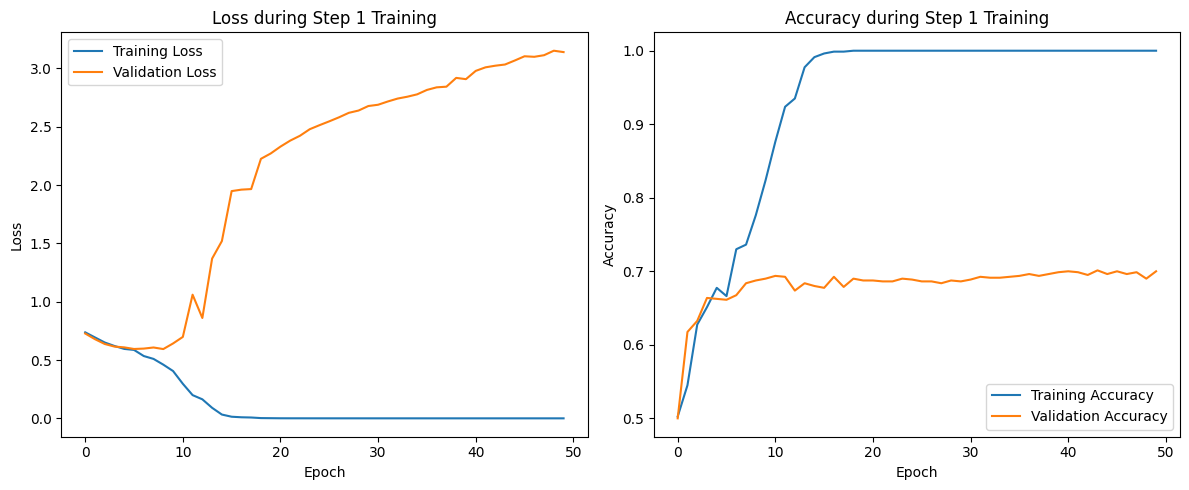

Overfitted model (model_overfit.pth) saved.


In [ ]:
# Ensure model_overfit, device, train_loader, val_loader,
# criterion_step1, and optimizer_step1 are defined correctly above this cell.

NUM_EPOCHS_STEP1 = 50  # DO NOT change

train_losses_step1 = []
train_accuracies_step1 = []
val_losses_step1 = []
val_accuracies_step1 = []

print(f"Starting Step 1 Training (Overfitting) for {NUM_EPOCHS_STEP1} epochs...")
print(f"Training on {len(train_loader.dataset)} images, Validating on {len(val_loader.dataset)} images.")

for epoch in range(NUM_EPOCHS_STEP1):

    # ---------------------- TRAIN ----------------------
    model_overfit.train()
    running_loss_train = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_STEP1} [Train]")
    for inputs, labels in progress_bar_train:
        # move to device + forward/backward/step
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer_step1.zero_grad()
        outputs = model_overfit(inputs)
        loss = criterion_step1(outputs, labels)
        loss.backward()
        optimizer_step1.step()

        # metrics
        running_loss_train += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()
        progress_bar_train.set_postfix({'loss': f"{loss.item():.4f}"})

    epoch_train_loss = running_loss_train / len(train_loader)
    epoch_train_accuracy = correct_predictions_train / total_samples_train
    train_losses_step1.append(epoch_train_loss)
    train_accuracies_step1.append(epoch_train_accuracy)

    # ---------------------- VAL ----------------------
    model_overfit.eval()
    running_loss_val = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_STEP1} [Val  ]")
        for inputs_val, labels_val in progress_bar_val:
            # forward only
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)

            outputs_val = model_overfit(inputs_val)
            loss_val = criterion_step1(outputs_val, labels_val)

            running_loss_val += loss_val.item()
            _, predicted_val = torch.max(outputs_val, 1)
            total_samples_val += labels_val.size(0)
            correct_predictions_val += (predicted_val == labels_val).sum().item()
            progress_bar_val.set_postfix({'loss': f"{loss_val.item():.4f}"})

    epoch_val_loss = running_loss_val / len(val_loader)
    epoch_val_accuracy = correct_predictions_val / total_samples_val
    val_losses_step1.append(epoch_val_loss)
    val_accuracies_step1.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS_STEP1}: "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

print("\nFinished Step 1 Training.")

# Plot training measurements
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_step1, label='Training Loss')
plt.plot(val_losses_step1, label='Validation Loss')
plt.title('Loss during Step 1 Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_step1, label='Training Accuracy')
plt.plot(val_accuracies_step1, label='Validation Accuracy')
plt.title('Accuracy during Step 1 Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the overfitted model's state dictionary
torch.save(model_overfit.state_dict(), 'model_overfit.pth')
print("Overfitted model (model_overfit.pth) saved.")


# Step 2 - Test model robustness

## Utilities - No modification needed

In [14]:
def denormalize_for_plot(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    tensor = tensor.cpu()
    mean_t = torch.tensor(mean).reshape(1, 3, 1, 1)
    std_t = torch.tensor(std).reshape(1, 3, 1, 1)
    denormalized_tensor = tensor * std_t + mean_t
    return torch.clamp(denormalized_tensor, 0, 1)


def plot_misclassified_perturbed_images(misclassified_examples, class_names,
                                        max_to_show=5, denormalize_fn=denormalize_for_plot,
                                        dpi_setting=50): # <---- increase dpi if needed
    """
    Plots misclassified perturbed images with reduced size for smaller notebook files.

    Args:
        misclassified_examples (list): List of misclassified example dicts.
        class_names (list): List of class names (e.g., ['Cat', 'Dog']).
        max_to_show (int): Maximum number of images to plot.
        denormalize_fn (function): Function to denormalize image tensors for plotting.
        dpi_setting (int): Dots per inch for the output figure.
    """
    if not misclassified_examples:
        print("\nNo misclassifications to show (or none were stored).")
        return

    num_to_plot = min(len(misclassified_examples), max_to_show)
    print(f"\nDisplaying up to {num_to_plot} misclassified perturbed images:")

    num_cols = min(num_to_plot, 5)
    num_rows = (num_to_plot + num_cols - 1) // num_cols

    fig_width_per_col = 2.0
    fig_height_per_row = 2.5

    fig, axes = plt.subplots(num_rows, num_cols,
                             figsize=(num_cols * fig_width_per_col, num_rows * fig_height_per_row),
                             dpi=dpi_setting)
    axes = np.array(axes).ravel()

    for i in range(num_to_plot):
        example = misclassified_examples[i]
        ax = axes[i]

        perturbed_img_to_show = denormalize_fn(example['perturbed_input'].unsqueeze(0)).squeeze(0)
        img_np = perturbed_img_to_show.permute(1, 2, 0).numpy()

        ax.imshow(img_np)
        true_class = class_names[example['true_label']]
        pred_class = class_names[example['predicted_label']]
        ax.set_title(f"True: {true_class}\nPred: {pred_class}", fontsize=8)
        ax.axis('off')

    for j in range(num_to_plot, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(pad=0.5)
    plt.show()

## Utilities - FGSM Attack (Must implement)

In [ ]:
# --- Ensure these helper functions are defined (from previous cells) ---
# def denormalize_for_plot(tensor, mean=[...], std=[...]): ...
# def plot_misclassified_perturbed_images(misclassified_examples, class_names, ...): ...
# def _fgsm_attack_perturbation(model, loss_fn, image_batch, label_batch, epsilon): ...
# --- You would have these in your notebook already or in a utility cell ---


# Main Robustness Evaluation Function
def evaluate_model_robustness(
    model_path,
    cnn_class,
    num_classes,
    data_path,
    device,
    attack_mode,
    epsilon,
    transform_fn=None,
    batch_size=32,
    max_misclassified_to_store=5,
    fgsm_criterion_class=nn.CrossEntropyLoss
):
    if transform_fn is None:
        transform_fn = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    model = cnn_class(num_classes=num_classes).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from '{model_path}'.")
    except FileNotFoundError:
        print(f"Error: Model file '{model_path}' not found.")
        raise
    except Exception as e:
        print(f"Error loading model state_dict: {e}")
        raise
    model.eval()

    # For consistent tracking of initially correct samples, shuffle=False is better.
    current_shuffle = True if attack_mode.lower() == "fgsm" else False

    dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform_fn)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=current_shuffle, num_workers=2)
    class_names_from_dataset = dataset.classes

    print(f"\nEvaluating robustness: Mode='{attack_mode}', Epsilon={epsilon}")
    print(f"Dataset: {data_path}, Images: {len(dataset)}, Batch Size: {batch_size}")

    # --- Evaluation Loop ---
    overall_correct_perturbed_count = 0
    total_samples_processed_count = 0
    misclassified_examples_list = []

    # Metrics for "initially correct" samples
    num_initially_correct_total = 0
    num_perturbed_correct_on_initially_correct_total = 0

    # FGSM specific
    fgsm_successful_flips_total = 0
    fgsm_targeted_for_attack_count = 0

    desc = f"Attack: {attack_mode.upper()}, Eps: {epsilon}"
    for inputs_batch, labels_batch in tqdm(dataloader, desc=desc):
        inputs_batch, labels_batch = inputs_batch.to(device), labels_batch.to(device)

        # Get original predictions for the entire batch (on clean data)
        with torch.no_grad():
            outputs_original_batch = model(inputs_batch)
            _, predicted_original_batch = torch.max(outputs_original_batch.data, 1)

        # Identify initially correct samples in this batch
        initially_correct_mask_batch = (predicted_original_batch == labels_batch)
        num_initially_correct_total += initially_correct_mask_batch.sum().item()

        # --- Generate Perturbations ---
        perturbed_inputs_final_batch = inputs_batch.clone() # Start with clean inputs

        if attack_mode.lower() == "uniform":
            with torch.no_grad():
                noise = epsilon * (2 * torch.rand_like(inputs_batch) - 1)
                perturbed_inputs_final_batch = inputs_batch + noise

        elif attack_mode.lower() == "fgsm":
            # For FGSM, we iterate through the batch and attack each initially correct sample individually
            temp_perturbed_for_fgsm_batch = inputs_batch.clone()
            for i in range(inputs_batch.size(0)):
                current_input = inputs_batch[i:i+1]
                current_label = labels_batch[i:i+1]

                if initially_correct_mask_batch[i].item(): # If this sample was initially correct
                    fgsm_targeted_for_attack_count += 1
                    input_for_attack = current_input.clone().detach().requires_grad_(True)
                    criterion_instance = fgsm_criterion_class()

                    perturbed_sample = _fgsm_attack_perturbation(
                        model, criterion_instance, input_for_attack, current_label, epsilon
                    )
                    temp_perturbed_for_fgsm_batch[i:i+1] = perturbed_sample
            perturbed_inputs_final_batch = temp_perturbed_for_fgsm_batch
        else:
            raise ValueError(f"Unknown attack_mode: {attack_mode}. Choose 'uniform' or 'fgsm'.")

        # --- Evaluate on the (potentially) perturbed batch ---
        with torch.no_grad():
            outputs_perturbed_batch = model(perturbed_inputs_final_batch)
            _, predicted_perturbed_batch = torch.max(outputs_perturbed_batch.data, 1)

        total_samples_processed_count += labels_batch.size(0)
        overall_correct_perturbed_count += (predicted_perturbed_batch == labels_batch).sum().item()

        # --- Update stats for "initially correct" subset and collect misclassified examples ---
        for i in range(labels_batch.size(0)):
            # Check if this specific sample was initially correct
            if initially_correct_mask_batch[i].item():
                # If it was initially correct, is it still correct after perturbation?
                if predicted_perturbed_batch[i].item() == labels_batch[i].item():
                    num_perturbed_correct_on_initially_correct_total += 1
                elif attack_mode.lower() == "fgsm": # If it was an FGSM attack and it flipped
                    fgsm_successful_flips_total +=1

            # Store misclassified examples (based on final perturbed prediction vs true label)
            if predicted_perturbed_batch[i].item() != labels_batch[i].item():
                if len(misclassified_examples_list) < max_misclassified_to_store:
                    example_data = {
                        'original_input': inputs_batch[i].cpu().detach(),
                        'perturbed_input': perturbed_inputs_final_batch[i].cpu().detach(),
                        'true_label': labels_batch[i].cpu().item(),
                        'predicted_label': predicted_perturbed_batch[i].cpu().item(),
                        'original_predicted_label': predicted_original_batch[i].cpu().item()
                    }
                    misclassified_examples_list.append(example_data)

    # --- Calculate final metrics ---
    overall_accuracy = 100 * overall_correct_perturbed_count / total_samples_processed_count if total_samples_processed_count > 0 else 0

    print(f"\n--- Robustness Test Summary ---")
    print(f"Mode: {attack_mode.upper()}, Epsilon: {epsilon}")
    print(f"Overall Accuracy on (Potentially) Perturbed Data: {overall_accuracy:.2f}% ({overall_correct_perturbed_count}/{total_samples_processed_count})")

    if num_initially_correct_total > 0:
        accuracy_on_initially_correct_perturbed = 100 * num_perturbed_correct_on_initially_correct_total / num_initially_correct_total
        print(f"Number of samples initially classified correctly by clean model: {num_initially_correct_total}")
        print(f"Accuracy on perturbed subset of these initially correct samples: {accuracy_on_initially_correct_perturbed:.2f}% ({num_perturbed_correct_on_initially_correct_total}/{num_initially_correct_total})")
        # You can also report misclassification rate on this subset:
        misclassification_rate_on_initially_correct = 100 * (num_initially_correct_total - num_perturbed_correct_on_initially_correct_total) / num_initially_correct_total
        print(f"Misclassification rate on perturbed subset of initially correct samples: {misclassification_rate_on_initially_correct:.2f}%")
    else:
        print("No samples were initially classified correctly by the clean model from this dataset.")

    if attack_mode.lower() == "fgsm":
        print(f"Number of initially correct samples targeted by FGSM: {fgsm_targeted_for_attack_count}")
        print(f"Number of successful FGSM flips (initially correct -> incorrect): {fgsm_successful_flips_total}")
        if fgsm_targeted_for_attack_count > 0:
            attack_success_rate_fgsm = 100 * fgsm_successful_flips_total / fgsm_targeted_for_attack_count
            print(f"FGSM Attack Success Rate on targeted candidates: {attack_success_rate_fgsm:.2f}%")

    return overall_accuracy, misclassified_examples_list, class_names_from_dataset

## Utilities - Attack Pass (No modification needed)

In [16]:
# --- Ensure these helper functions are defined (from previous cells) ---
# def denormalize_for_plot(tensor, mean=[...], std=[...]): ...
# def plot_misclassified_perturbed_images(misclassified_examples, class_names, ...): ...
# def _fgsm_attack_perturbation(model, loss_fn, image_batch, label_batch, epsilon): ...
# --- You would have these in your notebook already or in a utility cell ---


# Main Robustness Evaluation Function
def evaluate_model_robustness(
    model_path,
    cnn_class,
    num_classes,
    data_path,
    device,
    attack_mode,
    epsilon,
    transform_fn=None,
    batch_size=32,
    max_misclassified_to_store=5,
    fgsm_criterion_class=nn.CrossEntropyLoss
):
    if transform_fn is None:
        transform_fn = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    model = cnn_class(num_classes=num_classes).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Successfully loaded model from '{model_path}'.")
    except FileNotFoundError:
        print(f"Error: Model file '{model_path}' not found.")
        raise
    except Exception as e:
        print(f"Error loading model state_dict: {e}")
        raise
    model.eval()

    # For consistent tracking of initially correct samples, shuffle=False is better.
    current_shuffle = True if attack_mode.lower() == "fgsm" else False

    dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform_fn)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=current_shuffle, num_workers=2)
    class_names_from_dataset = dataset.classes

    print(f"\nEvaluating robustness: Mode='{attack_mode}', Epsilon={epsilon}")
    print(f"Dataset: {data_path}, Images: {len(dataset)}, Batch Size: {batch_size}")

    # --- Evaluation Loop ---
    overall_correct_perturbed_count = 0
    total_samples_processed_count = 0
    misclassified_examples_list = []

    # Metrics for "initially correct" samples
    num_initially_correct_total = 0
    num_perturbed_correct_on_initially_correct_total = 0

    # FGSM specific
    fgsm_successful_flips_total = 0
    fgsm_targeted_for_attack_count = 0

    desc = f"Attack: {attack_mode.upper()}, Eps: {epsilon}"
    for inputs_batch, labels_batch in tqdm(dataloader, desc=desc):
        inputs_batch, labels_batch = inputs_batch.to(device), labels_batch.to(device)

        # Get original predictions for the entire batch (on clean data)
        with torch.no_grad():
            outputs_original_batch = model(inputs_batch)
            _, predicted_original_batch = torch.max(outputs_original_batch.data, 1)

        # Identify initially correct samples in this batch
        initially_correct_mask_batch = (predicted_original_batch == labels_batch)
        num_initially_correct_total += initially_correct_mask_batch.sum().item()

        # --- Generate Perturbations ---
        perturbed_inputs_final_batch = inputs_batch.clone() # Start with clean inputs

        if attack_mode.lower() == "uniform":
            with torch.no_grad():
                noise = epsilon * (2 * torch.rand_like(inputs_batch) - 1)
                perturbed_inputs_final_batch = inputs_batch + noise

        elif attack_mode.lower() == "fgsm":
            # For FGSM, we iterate through the batch and attack each initially correct sample individually
            temp_perturbed_for_fgsm_batch = inputs_batch.clone()
            for i in range(inputs_batch.size(0)):
                current_input = inputs_batch[i:i+1]
                current_label = labels_batch[i:i+1]

                if initially_correct_mask_batch[i].item(): # If this sample was initially correct
                    fgsm_targeted_for_attack_count += 1
                    input_for_attack = current_input.clone().detach().requires_grad_(True)
                    criterion_instance = fgsm_criterion_class()

                    perturbed_sample = _fgsm_attack_perturbation(
                        model, criterion_instance, input_for_attack, current_label, epsilon
                    )
                    temp_perturbed_for_fgsm_batch[i:i+1] = perturbed_sample
            perturbed_inputs_final_batch = temp_perturbed_for_fgsm_batch
        else:
            raise ValueError(f"Unknown attack_mode: {attack_mode}. Choose 'uniform' or 'fgsm'.")

        # --- Evaluate on the (potentially) perturbed batch ---
        with torch.no_grad():
            outputs_perturbed_batch = model(perturbed_inputs_final_batch)
            _, predicted_perturbed_batch = torch.max(outputs_perturbed_batch.data, 1)

        total_samples_processed_count += labels_batch.size(0)
        overall_correct_perturbed_count += (predicted_perturbed_batch == labels_batch).sum().item()

        # --- Update stats for "initially correct" subset and collect misclassified examples ---
        for i in range(labels_batch.size(0)):
            # Check if this specific sample was initially correct
            if initially_correct_mask_batch[i].item():
                # If it was initially correct, is it still correct after perturbation?
                if predicted_perturbed_batch[i].item() == labels_batch[i].item():
                    num_perturbed_correct_on_initially_correct_total += 1
                elif attack_mode.lower() == "fgsm": # If it was an FGSM attack and it flipped
                    fgsm_successful_flips_total +=1

            # Store misclassified examples (based on final perturbed prediction vs true label)
            if predicted_perturbed_batch[i].item() != labels_batch[i].item():
                if len(misclassified_examples_list) < max_misclassified_to_store:
                    example_data = {
                        'original_input': inputs_batch[i].cpu().detach(),
                        'perturbed_input': perturbed_inputs_final_batch[i].cpu().detach(),
                        'true_label': labels_batch[i].cpu().item(),
                        'predicted_label': predicted_perturbed_batch[i].cpu().item(),
                        'original_predicted_label': predicted_original_batch[i].cpu().item()
                    }
                    misclassified_examples_list.append(example_data)

    # --- Calculate final metrics ---
    overall_accuracy = 100 * overall_correct_perturbed_count / total_samples_processed_count if total_samples_processed_count > 0 else 0

    print(f"\n--- Robustness Test Summary ---")
    print(f"Mode: {attack_mode.upper()}, Epsilon: {epsilon}")
    print(f"Overall Accuracy on (Potentially) Perturbed Data: {overall_accuracy:.2f}% ({overall_correct_perturbed_count}/{total_samples_processed_count})")

    if num_initially_correct_total > 0:
        accuracy_on_initially_correct_perturbed = 100 * num_perturbed_correct_on_initially_correct_total / num_initially_correct_total
        print(f"Number of samples initially classified correctly by clean model: {num_initially_correct_total}")
        print(f"Accuracy on perturbed subset of these initially correct samples: {accuracy_on_initially_correct_perturbed:.2f}% ({num_perturbed_correct_on_initially_correct_total}/{num_initially_correct_total})")
        # You can also report misclassification rate on this subset:
        misclassification_rate_on_initially_correct = 100 * (num_initially_correct_total - num_perturbed_correct_on_initially_correct_total) / num_initially_correct_total
        print(f"Misclassification rate on perturbed subset of initially correct samples: {misclassification_rate_on_initially_correct:.2f}%")
    else:
        print("No samples were initially classified correctly by the clean model from this dataset.")

    if attack_mode.lower() == "fgsm":
        print(f"Number of initially correct samples targeted by FGSM: {fgsm_targeted_for_attack_count}")
        print(f"Number of successful FGSM flips (initially correct -> incorrect): {fgsm_successful_flips_total}")
        if fgsm_targeted_for_attack_count > 0:
            attack_success_rate_fgsm = 100 * fgsm_successful_flips_total / fgsm_targeted_for_attack_count
            print(f"FGSM Attack Success Rate on targeted candidates: {attack_success_rate_fgsm:.2f}%")

    return overall_accuracy, misclassified_examples_list, class_names_from_dataset

## Utilities - Attack Driver Suite (No modification needed)

In [17]:
def run_robustness_evaluation_suite(
    model_path="/content/model_overfit.pth",
    cnn_class=OverfittingCNN,
    num_classes=2,
    device=device,
    train_data_path=train_data_path, # Path for optional training data tests
    val_data_path=val_data_path,   # Path for validation data tests
    # Define test configurations as a list of dictionaries
    tests_to_run = [
        {
            "test_name": "Uniform Noise on VALIDATION Data (Eps=0.25)",
            "data_source": "validation", # 'validation' or 'training'
            "attack_mode": "uniform",
            "epsilon": 0.25,
            "batch_size": 16,
            "max_misclassified_to_store": 10,
            "plot_results": True
        },
        {
            "test_name": "FGSM on VALIDATION Data (Eps=0.05)",
            "data_source": "validation",
            "attack_mode": "fgsm",
            "epsilon": 0.05,
            "batch_size": 16,
            "max_misclassified_to_store": 10,
            "plot_results": True
        },
        {
            "test_name": "Uniform Noise on TRAINING Data (Eps=0.25)",
            "data_source": "training", # 'validation' or 'training'
            "attack_mode": "uniform",
            "epsilon": 0.25,
            "batch_size": 16,
            "max_misclassified_to_store": 10,
            "plot_results": True
        },
        {
            "test_name": "FGSM on TRAINING Data (Eps=0.05)",
            "data_source": "training",
            "attack_mode": "fgsm",
            "epsilon": 0.05,
            "batch_size": 16,
            "max_misclassified_to_store": 10,
            "plot_results": True
        },
        # Add more test configurations here if needed
        # Example: Uniform noise on training data
        # {
        #     "test_name": "Uniform Noise on TRAINING Data (Eps=0.3)",
        #     "data_source": "training",
        #     "attack_mode": "uniform",
        #     "epsilon": 0.3,
        #     "batch_size": 32,
        #     "max_misclassified_to_store": 5,
        #     "plot_results": True
        # }
    ]
):
    """
    Runs a suite of robustness evaluations on a given model.

    Args:
        model_path (str): Path to the saved model (.pth file).
        cnn_class (type): The class of the CNN model (e.g., OverfittingCNN).
        num_classes (int): Number of output classes for the CNN.
        device (torch.device): The device to run on ('cuda' or 'cpu').
        train_data_path (str): Path to the training image data.
        val_data_path (str): Path to the validation image data.
        tests_to_run (list): A list of dictionaries, each defining a test configuration.
    """

    print(f"Starting Robustness Evaluation Suite for model: {model_path}\n")

    for test_config in tests_to_run:
        print("\n" + "="*60)
        print(f"RUNNING TEST: {test_config['test_name']}")
        print("="*60)

        current_data_path = ""
        if test_config["data_source"].lower() == "validation":
            current_data_path = val_data_path
        elif test_config["data_source"].lower() == "training":
            current_data_path = train_data_path
        else:
            print(f"Warning: Unknown data_source '{test_config['data_source']}' for test '{test_config['test_name']}'. Skipping.")
            continue

        if not os.path.exists(current_data_path):
            print(f"Warning: Data path '{current_data_path}' not found for test '{test_config['test_name']}'. Skipping.")
            continue


        accuracy, misclassified_list, class_names = evaluate_model_robustness(
            model_path=model_path,
            cnn_class=cnn_class,
            num_classes=num_classes,
            data_path=current_data_path,
            device=device,
            attack_mode=test_config["attack_mode"],
            epsilon=test_config["epsilon"],
            batch_size=test_config["batch_size"],
            max_misclassified_to_store=test_config["max_misclassified_to_store"]
        )

        if test_config.get("plot_results", False): # Check if plot_results is True
            plot_misclassified_perturbed_images(
                misclassified_examples=misclassified_list,
                class_names=class_names,
                max_to_show=test_config["max_misclassified_to_store"]
            )

    print("\n" + "="*60)
    print("Robustness Evaluation Suite Completed.")
    print("="*60)

## Run Robustness Test

Starting Robustness Evaluation Suite for model: /content/model_overfit.pth


RUNNING TEST: Uniform Noise on VALIDATION Data (Eps=0.25)
Successfully loaded model from '/content/model_overfit.pth'.

Evaluating robustness: Mode='uniform', Epsilon=0.25
Dataset: /content/Data/val, Images: 800, Batch Size: 16


Attack: UNIFORM, Eps: 0.25: 100%|██████████| 50/50 [00:03<00:00, 13.87it/s]



--- Robustness Test Summary ---
Mode: UNIFORM, Epsilon: 0.25
Overall Accuracy on (Potentially) Perturbed Data: 68.00% (544/800)
Number of samples initially classified correctly by clean model: 560
Accuracy on perturbed subset of these initially correct samples: 94.82% (531/560)
Misclassification rate on perturbed subset of initially correct samples: 5.18%

Displaying up to 10 misclassified perturbed images:


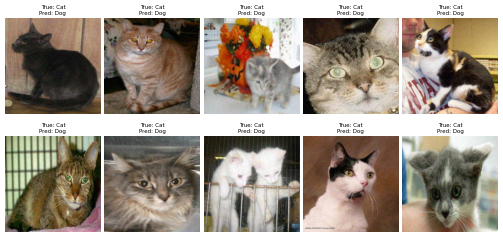


RUNNING TEST: FGSM on VALIDATION Data (Eps=0.05)
Successfully loaded model from '/content/model_overfit.pth'.

Evaluating robustness: Mode='fgsm', Epsilon=0.05
Dataset: /content/Data/val, Images: 800, Batch Size: 16


Attack: FGSM, Eps: 0.05: 100%|██████████| 50/50 [00:03<00:00, 12.74it/s]



--- Robustness Test Summary ---
Mode: FGSM, Epsilon: 0.05
Overall Accuracy on (Potentially) Perturbed Data: 3.88% (31/800)
Number of samples initially classified correctly by clean model: 560
Accuracy on perturbed subset of these initially correct samples: 5.54% (31/560)
Misclassification rate on perturbed subset of initially correct samples: 94.46%
Number of initially correct samples targeted by FGSM: 560
Number of successful FGSM flips (initially correct -> incorrect): 529
FGSM Attack Success Rate on targeted candidates: 94.46%

Displaying up to 10 misclassified perturbed images:


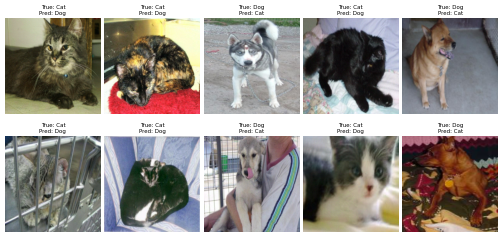


RUNNING TEST: Uniform Noise on TRAINING Data (Eps=0.25)
Successfully loaded model from '/content/model_overfit.pth'.

Evaluating robustness: Mode='uniform', Epsilon=0.25
Dataset: /content/Data/train, Images: 800, Batch Size: 16


Attack: UNIFORM, Eps: 0.25: 100%|██████████| 50/50 [00:03<00:00, 16.48it/s]



--- Robustness Test Summary ---
Mode: UNIFORM, Epsilon: 0.25
Overall Accuracy on (Potentially) Perturbed Data: 99.75% (798/800)
Number of samples initially classified correctly by clean model: 800
Accuracy on perturbed subset of these initially correct samples: 99.75% (798/800)
Misclassification rate on perturbed subset of initially correct samples: 0.25%

Displaying up to 2 misclassified perturbed images:


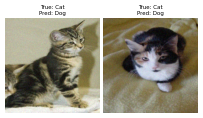


RUNNING TEST: FGSM on TRAINING Data (Eps=0.05)
Successfully loaded model from '/content/model_overfit.pth'.

Evaluating robustness: Mode='fgsm', Epsilon=0.05
Dataset: /content/Data/train, Images: 800, Batch Size: 16


Attack: FGSM, Eps: 0.05: 100%|██████████| 50/50 [00:05<00:00,  9.23it/s]



--- Robustness Test Summary ---
Mode: FGSM, Epsilon: 0.05
Overall Accuracy on (Potentially) Perturbed Data: 7.25% (58/800)
Number of samples initially classified correctly by clean model: 800
Accuracy on perturbed subset of these initially correct samples: 7.25% (58/800)
Misclassification rate on perturbed subset of initially correct samples: 92.75%
Number of initially correct samples targeted by FGSM: 800
Number of successful FGSM flips (initially correct -> incorrect): 742
FGSM Attack Success Rate on targeted candidates: 92.75%

Displaying up to 10 misclassified perturbed images:


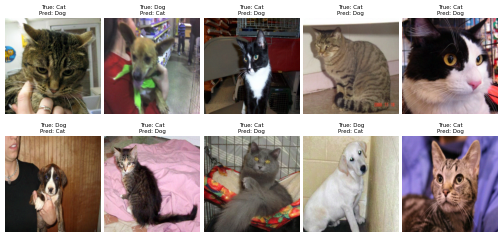


Robustness Evaluation Suite Completed.


In [18]:
run_robustness_evaluation_suite()

# Step 3 - A more robust model & training
You can copy over many of these from step 1.

## Transforms & DataLoaders

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Transforms & DataLoaders
transform_train_regularized = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5]),
])

transform_val_regularized = transforms.Composطe([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5]),
])

train_data_path_step3 = "/Users/tarasetareh/Desktop/Data/train"  
val_data_path_step3   = "/Users/tarasetareh/Desktop/Data/val"  

train_dataset_step3 = ImageFolder(root=train_data_path_step3, transform=transform_train_regularized)
val_dataset_step3   = ImageFolder(root=val_data_path_step3,   transform=transform_val_regularized)

batch_size_step3 = 32
train_dataloader_step3 = DataLoader(train_dataset_step3, batch_size=batch_size_step3, shuffle=True)
val_dataloader_step3   = DataLoader(val_dataset_step3,   batch_size=batch_size_step3, shuffle=False)

print(f"Step 3 Training Dataloader: Using data augmentation.")
print(f"Number of images in Step 3 train dataset: {len(train_dataset_step3)}")
print(f"Number of images in Step 3 validation dataset: {len(val_dataset_step3)}")


Step 3 Training Dataloader: Using data augmentation.
Number of images in Step 3 train dataset: 800
Number of images in Step 3 validation dataset: 800


## Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RegularizedCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(RegularizedCNN, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                         
            nn.Dropout2d(p=dropout_rate*0.3)            
        )  # Output: (B, 16, 112, 112)

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                        
            nn.Dropout2d(p=dropout_rate*0.4)
        )  # Output: (B, 32, 56, 56)

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                       
            nn.Dropout2d(p=dropout_rate*0.5)
        )  # Output: (B, 64, 28, 28)

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),                         
            nn.Dropout2d(p=dropout_rate*0.5)
        )  # Output: (B, 128, 14, 14)

        self.flattened_size = 128 * 14 * 14 

        self.fc_block = nn.Sequential(
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x


In [25]:
# Instantiate the regularized model and move to device
# device should be defined from Step 1
dropout_val = 0.5 # A common starting point for dropout
model_regularized = RegularizedCNN(num_classes=2, dropout_rate=dropout_val).to(device)

# Print model summary
try:
    from torchsummary import summary
    summary(model_regularized, input_size=(3, 224, 224))
except ImportError:
    print(model_regularized)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
           Dropout-5         [-1, 16, 112, 112]               0
            Conv2d-6         [-1, 32, 112, 112]           4,640
       BatchNorm2d-7         [-1, 32, 112, 112]              64
              ReLU-8         [-1, 32, 112, 112]               0
         MaxPool2d-9           [-1, 32, 56, 56]               0
          Dropout-10           [-1, 32, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          18,496
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
        MaxPool2d-14           [-1, 64,

## Loss, Optimizer & other loop objects

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion_step3 = nn.CrossEntropyLoss()   

optimizer_step3 = optim.Adam(model_regularized.parameters(), lr=1e-3, weight_decay=1e-4)
train_loader = train_dataloader_step3
val_loader   = val_dataloader_step3

## Training Loop

Starting Step 3 Training (Robust) for 200 epochs...
Training on 800 images, Validating on 800 images.


Epoch 1/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.44it/s, loss=1.5785]


Epoch 1/200: Train Loss: 0.8515, Train Acc: 0.5300 | Val Loss: 0.9051, Val Acc: 0.5000


Epoch 2/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.44it/s, loss=1.0277]


Epoch 2/200: Train Loss: 0.6990, Train Acc: 0.5962 | Val Loss: 0.7308, Val Acc: 0.5000


Epoch 3/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.20it/s, loss=0.9103]


Epoch 3/200: Train Loss: 0.6684, Train Acc: 0.6125 | Val Loss: 0.7041, Val Acc: 0.5050


Epoch 4/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.69it/s, loss=1.5014]


Epoch 4/200: Train Loss: 0.6753, Train Acc: 0.6062 | Val Loss: 0.8664, Val Acc: 0.5000


Epoch 5/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.81it/s, loss=0.9899]


Epoch 5/200: Train Loss: 0.6337, Train Acc: 0.6687 | Val Loss: 0.7062, Val Acc: 0.5188


Epoch 6/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.37it/s, loss=1.3644]


Epoch 6/200: Train Loss: 0.6244, Train Acc: 0.6675 | Val Loss: 0.8137, Val Acc: 0.5025


Epoch 7/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.20it/s, loss=2.0743]


Epoch 7/200: Train Loss: 0.6233, Train Acc: 0.6562 | Val Loss: 1.0861, Val Acc: 0.5012


Epoch 8/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.79it/s, loss=1.5275]


Epoch 8/200: Train Loss: 0.5907, Train Acc: 0.6787 | Val Loss: 0.8592, Val Acc: 0.5038


Epoch 9/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.80it/s, loss=1.4376]


Epoch 9/200: Train Loss: 0.5898, Train Acc: 0.6663 | Val Loss: 0.8304, Val Acc: 0.5088


Epoch 10/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.22it/s, loss=0.9778]


Epoch 10/200: Train Loss: 0.5869, Train Acc: 0.6925 | Val Loss: 0.6925, Val Acc: 0.5437


Epoch 11/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.00it/s, loss=1.4995]


Epoch 11/200: Train Loss: 0.5841, Train Acc: 0.6850 | Val Loss: 0.8272, Val Acc: 0.5262


Epoch 12/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=1.4435]


Epoch 12/200: Train Loss: 0.5641, Train Acc: 0.6963 | Val Loss: 0.8459, Val Acc: 0.5075


Epoch 13/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.09it/s, loss=1.8407]


Epoch 13/200: Train Loss: 0.5786, Train Acc: 0.6875 | Val Loss: 0.9486, Val Acc: 0.5212


Epoch 14/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.93it/s, loss=2.2871]


Epoch 14/200: Train Loss: 0.5620, Train Acc: 0.6913 | Val Loss: 1.1916, Val Acc: 0.5075


Epoch 15/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.00it/s, loss=1.8916]


Epoch 15/200: Train Loss: 0.5395, Train Acc: 0.7300 | Val Loss: 1.0125, Val Acc: 0.5138


Epoch 16/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=1.1465]


Epoch 16/200: Train Loss: 0.5432, Train Acc: 0.7100 | Val Loss: 0.6933, Val Acc: 0.5650


Epoch 17/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=1.6472]


Epoch 17/200: Train Loss: 0.5269, Train Acc: 0.7288 | Val Loss: 0.9284, Val Acc: 0.5238


Epoch 18/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.66it/s, loss=2.1615]


Epoch 18/200: Train Loss: 0.5242, Train Acc: 0.7350 | Val Loss: 1.1012, Val Acc: 0.5175


Epoch 19/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.17it/s, loss=1.7710]


Epoch 19/200: Train Loss: 0.5327, Train Acc: 0.7150 | Val Loss: 0.9069, Val Acc: 0.5525


Epoch 20/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.04it/s, loss=1.5261]


Epoch 20/200: Train Loss: 0.4944, Train Acc: 0.7712 | Val Loss: 0.8261, Val Acc: 0.5537


Epoch 21/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.42it/s, loss=2.5119]


Epoch 21/200: Train Loss: 0.5114, Train Acc: 0.7400 | Val Loss: 1.2071, Val Acc: 0.5150


Epoch 22/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.20it/s, loss=2.1688]


Epoch 22/200: Train Loss: 0.4963, Train Acc: 0.7550 | Val Loss: 1.0966, Val Acc: 0.5387


Epoch 23/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.56it/s, loss=2.4011]


Epoch 23/200: Train Loss: 0.5024, Train Acc: 0.7400 | Val Loss: 1.1787, Val Acc: 0.5275


Epoch 24/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s, loss=1.8873]


Epoch 24/200: Train Loss: 0.4888, Train Acc: 0.7712 | Val Loss: 0.9161, Val Acc: 0.5613


Epoch 25/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.95it/s, loss=2.8049]


Epoch 25/200: Train Loss: 0.4645, Train Acc: 0.7762 | Val Loss: 1.3824, Val Acc: 0.5138


Epoch 26/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.35it/s, loss=1.9636]


Epoch 26/200: Train Loss: 0.4834, Train Acc: 0.7612 | Val Loss: 0.9415, Val Acc: 0.5613


Epoch 27/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.28it/s, loss=2.7703]


Epoch 27/200: Train Loss: 0.4555, Train Acc: 0.7812 | Val Loss: 1.3243, Val Acc: 0.5175


Epoch 28/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.86it/s, loss=1.4908]


Epoch 28/200: Train Loss: 0.4446, Train Acc: 0.8025 | Val Loss: 0.7306, Val Acc: 0.6275


Epoch 29/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.21it/s, loss=2.0807]


Epoch 29/200: Train Loss: 0.4328, Train Acc: 0.7987 | Val Loss: 1.0653, Val Acc: 0.5487


Epoch 30/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s, loss=1.9561]


Epoch 30/200: Train Loss: 0.4587, Train Acc: 0.7887 | Val Loss: 0.9423, Val Acc: 0.5763


Epoch 31/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.73it/s, loss=1.9301]


Epoch 31/200: Train Loss: 0.4146, Train Acc: 0.8100 | Val Loss: 0.9221, Val Acc: 0.5863


Epoch 32/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.01it/s, loss=2.3399]


Epoch 32/200: Train Loss: 0.4427, Train Acc: 0.7913 | Val Loss: 1.0476, Val Acc: 0.5700


Epoch 33/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s, loss=2.3212]


Epoch 33/200: Train Loss: 0.3965, Train Acc: 0.8225 | Val Loss: 1.0809, Val Acc: 0.5613


Epoch 34/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.08it/s, loss=1.3298]


Epoch 34/200: Train Loss: 0.4058, Train Acc: 0.8263 | Val Loss: 0.6736, Val Acc: 0.6900


Epoch 35/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.98it/s, loss=2.1050]


Epoch 35/200: Train Loss: 0.4295, Train Acc: 0.7963 | Val Loss: 0.9789, Val Acc: 0.6000


Epoch 36/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.49it/s, loss=2.6595]


Epoch 36/200: Train Loss: 0.4184, Train Acc: 0.8137 | Val Loss: 1.2779, Val Acc: 0.5275


Epoch 37/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.87it/s, loss=1.8649]


Epoch 37/200: Train Loss: 0.4058, Train Acc: 0.8187 | Val Loss: 0.9535, Val Acc: 0.5938


Epoch 38/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.11it/s, loss=2.3078]


Epoch 38/200: Train Loss: 0.4212, Train Acc: 0.8013 | Val Loss: 1.0610, Val Acc: 0.5713


Epoch 39/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=1.8021]


Epoch 39/200: Train Loss: 0.3849, Train Acc: 0.8175 | Val Loss: 0.8137, Val Acc: 0.6262


Epoch 40/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.51it/s, loss=2.8529]


Epoch 40/200: Train Loss: 0.3833, Train Acc: 0.8163 | Val Loss: 1.2844, Val Acc: 0.5487


Epoch 41/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.89it/s, loss=1.6867]


Epoch 41/200: Train Loss: 0.3632, Train Acc: 0.8263 | Val Loss: 0.7182, Val Acc: 0.6687


Epoch 42/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.82it/s, loss=2.0921]


Epoch 42/200: Train Loss: 0.4008, Train Acc: 0.8087 | Val Loss: 0.9146, Val Acc: 0.6175


Epoch 43/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=2.1225]


Epoch 43/200: Train Loss: 0.3565, Train Acc: 0.8425 | Val Loss: 0.9204, Val Acc: 0.6050


Epoch 44/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=1.8702]


Epoch 44/200: Train Loss: 0.3403, Train Acc: 0.8512 | Val Loss: 0.7790, Val Acc: 0.6412


Epoch 45/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.51it/s, loss=2.2507]


Epoch 45/200: Train Loss: 0.3671, Train Acc: 0.8263 | Val Loss: 1.0266, Val Acc: 0.6162


Epoch 46/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.60it/s, loss=2.2076]


Epoch 46/200: Train Loss: 0.3740, Train Acc: 0.8250 | Val Loss: 0.8966, Val Acc: 0.6438


Epoch 47/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=2.5689]


Epoch 47/200: Train Loss: 0.3137, Train Acc: 0.8788 | Val Loss: 1.0764, Val Acc: 0.6025


Epoch 48/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.87it/s, loss=1.9696]


Epoch 48/200: Train Loss: 0.3586, Train Acc: 0.8325 | Val Loss: 0.8812, Val Acc: 0.6388


Epoch 49/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.81it/s, loss=2.9229]


Epoch 49/200: Train Loss: 0.3297, Train Acc: 0.8462 | Val Loss: 1.2564, Val Acc: 0.5713


Epoch 50/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.93it/s, loss=2.3110]


Epoch 50/200: Train Loss: 0.3217, Train Acc: 0.8700 | Val Loss: 0.9365, Val Acc: 0.6512


Epoch 51/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=2.4686]


Epoch 51/200: Train Loss: 0.3091, Train Acc: 0.8725 | Val Loss: 1.1003, Val Acc: 0.6062


Epoch 52/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.85it/s, loss=2.1887]


Epoch 52/200: Train Loss: 0.3206, Train Acc: 0.8525 | Val Loss: 0.9115, Val Acc: 0.6575


Epoch 53/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.92it/s, loss=2.3397]


Epoch 53/200: Train Loss: 0.3217, Train Acc: 0.8625 | Val Loss: 1.0782, Val Acc: 0.6075


Epoch 54/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.03it/s, loss=2.5564]


Epoch 54/200: Train Loss: 0.3091, Train Acc: 0.8712 | Val Loss: 1.0788, Val Acc: 0.6062


Epoch 55/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.63it/s, loss=2.5627]


Epoch 55/200: Train Loss: 0.3225, Train Acc: 0.8588 | Val Loss: 1.1278, Val Acc: 0.6075


Epoch 56/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=2.7920]


Epoch 56/200: Train Loss: 0.3149, Train Acc: 0.8738 | Val Loss: 1.2103, Val Acc: 0.5913


Epoch 57/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.00it/s, loss=1.9657]


Epoch 57/200: Train Loss: 0.2822, Train Acc: 0.8800 | Val Loss: 0.8980, Val Acc: 0.6600


Epoch 58/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=2.3060]


Epoch 58/200: Train Loss: 0.3407, Train Acc: 0.8588 | Val Loss: 1.0440, Val Acc: 0.6138


Epoch 59/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.06it/s, loss=2.9506]


Epoch 59/200: Train Loss: 0.2813, Train Acc: 0.8762 | Val Loss: 1.2732, Val Acc: 0.5800


Epoch 60/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  8.00it/s, loss=2.9856]


Epoch 60/200: Train Loss: 0.2894, Train Acc: 0.8900 | Val Loss: 1.1783, Val Acc: 0.6188


Epoch 61/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.14it/s, loss=1.4351]


Epoch 61/200: Train Loss: 0.3235, Train Acc: 0.8438 | Val Loss: 0.6702, Val Acc: 0.7100


Epoch 62/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=2.3943]


Epoch 62/200: Train Loss: 0.2923, Train Acc: 0.8875 | Val Loss: 1.0481, Val Acc: 0.6338


Epoch 63/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.92it/s, loss=2.1501]


Epoch 63/200: Train Loss: 0.2732, Train Acc: 0.8825 | Val Loss: 0.8760, Val Acc: 0.6663


Epoch 64/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.68it/s, loss=2.2431]


Epoch 64/200: Train Loss: 0.2596, Train Acc: 0.8825 | Val Loss: 0.9566, Val Acc: 0.6475


Epoch 65/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s, loss=2.8343]


Epoch 65/200: Train Loss: 0.3056, Train Acc: 0.8575 | Val Loss: 1.2428, Val Acc: 0.6038


Epoch 66/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s, loss=2.6267]


Epoch 66/200: Train Loss: 0.2611, Train Acc: 0.8775 | Val Loss: 1.1268, Val Acc: 0.6212


Epoch 67/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s, loss=2.2780]


Epoch 67/200: Train Loss: 0.2864, Train Acc: 0.8800 | Val Loss: 1.0631, Val Acc: 0.6200


Epoch 68/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.06it/s, loss=2.3569]


Epoch 68/200: Train Loss: 0.2950, Train Acc: 0.8800 | Val Loss: 1.0503, Val Acc: 0.6262


Epoch 69/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.50it/s, loss=1.8347]


Epoch 69/200: Train Loss: 0.2721, Train Acc: 0.8775 | Val Loss: 0.8223, Val Acc: 0.6637


Epoch 70/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.00it/s, loss=2.1240]


Epoch 70/200: Train Loss: 0.2470, Train Acc: 0.8950 | Val Loss: 0.8824, Val Acc: 0.6625


Epoch 71/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=1.8595]


Epoch 71/200: Train Loss: 0.2799, Train Acc: 0.8825 | Val Loss: 0.9135, Val Acc: 0.6500


Epoch 72/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.69it/s, loss=1.6717]


Epoch 72/200: Train Loss: 0.3327, Train Acc: 0.8525 | Val Loss: 0.7203, Val Acc: 0.7100


Epoch 73/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.02it/s, loss=2.0679]


Epoch 73/200: Train Loss: 0.2468, Train Acc: 0.8950 | Val Loss: 0.8995, Val Acc: 0.6650


Epoch 74/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s, loss=2.5207]


Epoch 74/200: Train Loss: 0.2851, Train Acc: 0.8675 | Val Loss: 1.0745, Val Acc: 0.6350


Epoch 75/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.06it/s, loss=1.8044]


Epoch 75/200: Train Loss: 0.2696, Train Acc: 0.8850 | Val Loss: 0.7606, Val Acc: 0.7000


Epoch 76/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s, loss=1.9678]


Epoch 76/200: Train Loss: 0.2401, Train Acc: 0.9025 | Val Loss: 0.8390, Val Acc: 0.6713


Epoch 77/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.70it/s, loss=2.2559]


Epoch 77/200: Train Loss: 0.2455, Train Acc: 0.8950 | Val Loss: 0.9014, Val Acc: 0.6650


Epoch 78/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.22it/s, loss=3.5371]


Epoch 78/200: Train Loss: 0.2662, Train Acc: 0.8800 | Val Loss: 1.4394, Val Acc: 0.5925


Epoch 79/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.30it/s, loss=2.8447]


Epoch 79/200: Train Loss: 0.2362, Train Acc: 0.9050 | Val Loss: 1.1473, Val Acc: 0.6188


Epoch 80/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.12it/s, loss=2.2940]


Epoch 80/200: Train Loss: 0.2737, Train Acc: 0.8875 | Val Loss: 0.9942, Val Acc: 0.6538


Epoch 81/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.66it/s, loss=1.6271]


Epoch 81/200: Train Loss: 0.2499, Train Acc: 0.8912 | Val Loss: 0.7436, Val Acc: 0.7037


Epoch 82/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.74it/s, loss=1.9281]


Epoch 82/200: Train Loss: 0.2283, Train Acc: 0.9050 | Val Loss: 0.8255, Val Acc: 0.6875


Epoch 83/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.17it/s, loss=2.3163]


Epoch 83/200: Train Loss: 0.2743, Train Acc: 0.8888 | Val Loss: 1.0057, Val Acc: 0.6450


Epoch 84/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.20it/s, loss=2.6814]


Epoch 84/200: Train Loss: 0.2434, Train Acc: 0.8988 | Val Loss: 1.1561, Val Acc: 0.6312


Epoch 85/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=2.3544]


Epoch 85/200: Train Loss: 0.2210, Train Acc: 0.9000 | Val Loss: 1.0649, Val Acc: 0.6500


Epoch 86/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.74it/s, loss=1.9880]


Epoch 86/200: Train Loss: 0.2287, Train Acc: 0.9113 | Val Loss: 0.8473, Val Acc: 0.6750


Epoch 87/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.15it/s, loss=2.6394]


Epoch 87/200: Train Loss: 0.2342, Train Acc: 0.8988 | Val Loss: 1.1540, Val Acc: 0.6125


Epoch 88/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.11it/s, loss=2.6157]


Epoch 88/200: Train Loss: 0.1881, Train Acc: 0.9200 | Val Loss: 1.0913, Val Acc: 0.6362


Epoch 89/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.24it/s, loss=1.9889]


Epoch 89/200: Train Loss: 0.2153, Train Acc: 0.9025 | Val Loss: 0.8620, Val Acc: 0.6837


Epoch 90/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.78it/s, loss=2.5382]


Epoch 90/200: Train Loss: 0.2013, Train Acc: 0.9225 | Val Loss: 1.0893, Val Acc: 0.6438


Epoch 91/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  8.26it/s, loss=3.3029]


Epoch 91/200: Train Loss: 0.2149, Train Acc: 0.9113 | Val Loss: 1.3601, Val Acc: 0.6050


Epoch 92/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.91it/s, loss=2.8351]


Epoch 92/200: Train Loss: 0.2312, Train Acc: 0.9062 | Val Loss: 1.0747, Val Acc: 0.6500


Epoch 93/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.60it/s, loss=2.4436]


Epoch 93/200: Train Loss: 0.2218, Train Acc: 0.9187 | Val Loss: 0.9929, Val Acc: 0.6737


Epoch 94/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=2.1681]


Epoch 94/200: Train Loss: 0.2238, Train Acc: 0.9137 | Val Loss: 1.0129, Val Acc: 0.6650


Epoch 95/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.55it/s, loss=1.2444]


Epoch 95/200: Train Loss: 0.2040, Train Acc: 0.9187 | Val Loss: 0.6135, Val Acc: 0.7475


Epoch 96/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.76it/s, loss=2.5440]


Epoch 96/200: Train Loss: 0.2045, Train Acc: 0.9163 | Val Loss: 0.9928, Val Acc: 0.6863


Epoch 97/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.92it/s, loss=2.3455]


Epoch 97/200: Train Loss: 0.2575, Train Acc: 0.8900 | Val Loss: 0.9885, Val Acc: 0.6650


Epoch 98/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=2.3291]


Epoch 98/200: Train Loss: 0.2448, Train Acc: 0.9050 | Val Loss: 0.9399, Val Acc: 0.6863


Epoch 99/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.48it/s, loss=3.0094]


Epoch 99/200: Train Loss: 0.2391, Train Acc: 0.9025 | Val Loss: 1.1445, Val Acc: 0.6562


Epoch 100/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.54it/s, loss=2.4424]


Epoch 100/200: Train Loss: 0.2418, Train Acc: 0.9038 | Val Loss: 0.9961, Val Acc: 0.6587


Epoch 101/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=1.8372]


Epoch 101/200: Train Loss: 0.2135, Train Acc: 0.9150 | Val Loss: 0.7487, Val Acc: 0.7262


Epoch 102/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.67it/s, loss=2.8606]


Epoch 102/200: Train Loss: 0.2226, Train Acc: 0.9100 | Val Loss: 1.1757, Val Acc: 0.6575


Epoch 103/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.79it/s, loss=1.7621]


Epoch 103/200: Train Loss: 0.2185, Train Acc: 0.9187 | Val Loss: 0.7569, Val Acc: 0.7125


Epoch 104/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  8.13it/s, loss=2.2522]


Epoch 104/200: Train Loss: 0.2187, Train Acc: 0.9075 | Val Loss: 0.8706, Val Acc: 0.7037


Epoch 105/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.68it/s, loss=2.0343]


Epoch 105/200: Train Loss: 0.1623, Train Acc: 0.9337 | Val Loss: 0.8257, Val Acc: 0.7125


Epoch 106/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.89it/s, loss=2.4601]


Epoch 106/200: Train Loss: 0.2050, Train Acc: 0.9100 | Val Loss: 0.9983, Val Acc: 0.6887


Epoch 107/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.74it/s, loss=2.1609]


Epoch 107/200: Train Loss: 0.2019, Train Acc: 0.9200 | Val Loss: 0.9256, Val Acc: 0.7000


Epoch 108/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.41it/s, loss=2.2824]


Epoch 108/200: Train Loss: 0.1976, Train Acc: 0.9175 | Val Loss: 0.8813, Val Acc: 0.6975


Epoch 109/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.46it/s, loss=2.0637]


Epoch 109/200: Train Loss: 0.1980, Train Acc: 0.9150 | Val Loss: 0.8608, Val Acc: 0.7050


Epoch 110/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.03it/s, loss=2.0277]


Epoch 110/200: Train Loss: 0.2157, Train Acc: 0.9113 | Val Loss: 0.7857, Val Acc: 0.7225


Epoch 111/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.74it/s, loss=1.9153]


Epoch 111/200: Train Loss: 0.1936, Train Acc: 0.9175 | Val Loss: 0.8350, Val Acc: 0.7125


Epoch 112/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.86it/s, loss=2.5140]


Epoch 112/200: Train Loss: 0.1725, Train Acc: 0.9275 | Val Loss: 1.0213, Val Acc: 0.6750


Epoch 113/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.81it/s, loss=2.5475]


Epoch 113/200: Train Loss: 0.1872, Train Acc: 0.9175 | Val Loss: 1.0177, Val Acc: 0.7000


Epoch 114/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.74it/s, loss=1.8022]


Epoch 114/200: Train Loss: 0.2485, Train Acc: 0.9050 | Val Loss: 0.7588, Val Acc: 0.7163


Epoch 115/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.95it/s, loss=2.2039]


Epoch 115/200: Train Loss: 0.1692, Train Acc: 0.9313 | Val Loss: 0.9426, Val Acc: 0.6750


Epoch 116/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.75it/s, loss=2.7063]


Epoch 116/200: Train Loss: 0.1815, Train Acc: 0.9300 | Val Loss: 1.0601, Val Acc: 0.6775


Epoch 117/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.68it/s, loss=2.5340]


Epoch 117/200: Train Loss: 0.2248, Train Acc: 0.9012 | Val Loss: 1.0090, Val Acc: 0.6825


Epoch 118/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.92it/s, loss=1.7090]


Epoch 118/200: Train Loss: 0.1985, Train Acc: 0.9150 | Val Loss: 0.8314, Val Acc: 0.7188


Epoch 119/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.62it/s, loss=1.9112]


Epoch 119/200: Train Loss: 0.1767, Train Acc: 0.9325 | Val Loss: 0.7976, Val Acc: 0.7075


Epoch 120/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.87it/s, loss=2.1772]


Epoch 120/200: Train Loss: 0.2016, Train Acc: 0.9213 | Val Loss: 0.9139, Val Acc: 0.6900


Epoch 121/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.91it/s, loss=1.6661]


Epoch 121/200: Train Loss: 0.1744, Train Acc: 0.9287 | Val Loss: 0.6994, Val Acc: 0.7412


Epoch 122/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=2.8013]


Epoch 122/200: Train Loss: 0.1953, Train Acc: 0.9200 | Val Loss: 1.1087, Val Acc: 0.6550


Epoch 123/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  8.05it/s, loss=2.5172]


Epoch 123/200: Train Loss: 0.1778, Train Acc: 0.9250 | Val Loss: 1.0465, Val Acc: 0.6613


Epoch 124/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.07it/s, loss=2.2116]


Epoch 124/200: Train Loss: 0.1730, Train Acc: 0.9375 | Val Loss: 0.9425, Val Acc: 0.6913


Epoch 125/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.95it/s, loss=2.5573]


Epoch 125/200: Train Loss: 0.1641, Train Acc: 0.9425 | Val Loss: 1.0505, Val Acc: 0.6562


Epoch 126/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.09it/s, loss=1.9526]


Epoch 126/200: Train Loss: 0.2134, Train Acc: 0.9100 | Val Loss: 0.8188, Val Acc: 0.7075


Epoch 127/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.01it/s, loss=1.9677]


Epoch 127/200: Train Loss: 0.1844, Train Acc: 0.9237 | Val Loss: 0.8473, Val Acc: 0.6925


Epoch 128/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.63it/s, loss=1.8354]


Epoch 128/200: Train Loss: 0.2002, Train Acc: 0.9250 | Val Loss: 0.8359, Val Acc: 0.6887


Epoch 129/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.76it/s, loss=1.4942]


Epoch 129/200: Train Loss: 0.1885, Train Acc: 0.9287 | Val Loss: 0.5869, Val Acc: 0.7688


Epoch 130/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.74it/s, loss=1.4823]


Epoch 130/200: Train Loss: 0.1790, Train Acc: 0.9325 | Val Loss: 0.6540, Val Acc: 0.7362


Epoch 131/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.85it/s, loss=2.0721]


Epoch 131/200: Train Loss: 0.1530, Train Acc: 0.9400 | Val Loss: 0.8801, Val Acc: 0.7063


Epoch 132/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.76it/s, loss=1.8543]


Epoch 132/200: Train Loss: 0.1764, Train Acc: 0.9250 | Val Loss: 0.7600, Val Acc: 0.7225


Epoch 133/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.52it/s, loss=1.8490]


Epoch 133/200: Train Loss: 0.1687, Train Acc: 0.9313 | Val Loss: 0.7569, Val Acc: 0.7238


Epoch 134/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.82it/s, loss=2.5094]


Epoch 134/200: Train Loss: 0.1645, Train Acc: 0.9387 | Val Loss: 1.0633, Val Acc: 0.6750


Epoch 135/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.92it/s, loss=3.4239]


Epoch 135/200: Train Loss: 0.1775, Train Acc: 0.9275 | Val Loss: 1.3396, Val Acc: 0.6488


Epoch 136/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.83it/s, loss=2.2564]


Epoch 136/200: Train Loss: 0.1640, Train Acc: 0.9387 | Val Loss: 0.9802, Val Acc: 0.6913


Epoch 137/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.82it/s, loss=2.0168]


Epoch 137/200: Train Loss: 0.1873, Train Acc: 0.9300 | Val Loss: 0.8558, Val Acc: 0.7100


Epoch 138/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.51it/s, loss=2.1963]


Epoch 138/200: Train Loss: 0.1616, Train Acc: 0.9437 | Val Loss: 0.8717, Val Acc: 0.7137


Epoch 139/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.86it/s, loss=1.9694]


Epoch 139/200: Train Loss: 0.1650, Train Acc: 0.9375 | Val Loss: 0.8504, Val Acc: 0.7125


Epoch 140/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.75it/s, loss=2.9420]


Epoch 140/200: Train Loss: 0.1650, Train Acc: 0.9363 | Val Loss: 1.1978, Val Acc: 0.6488


Epoch 141/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.92it/s, loss=2.2586]


Epoch 141/200: Train Loss: 0.1761, Train Acc: 0.9150 | Val Loss: 0.9403, Val Acc: 0.6987


Epoch 142/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.77it/s, loss=2.2238]


Epoch 142/200: Train Loss: 0.1572, Train Acc: 0.9487 | Val Loss: 0.9988, Val Acc: 0.6737


Epoch 143/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.58it/s, loss=2.4388]


Epoch 143/200: Train Loss: 0.1874, Train Acc: 0.9337 | Val Loss: 1.0280, Val Acc: 0.6775


Epoch 144/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.10it/s, loss=3.1221]


Epoch 144/200: Train Loss: 0.1334, Train Acc: 0.9563 | Val Loss: 1.3147, Val Acc: 0.6175


Epoch 145/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.96it/s, loss=2.6093]


Epoch 145/200: Train Loss: 0.1801, Train Acc: 0.9263 | Val Loss: 1.0557, Val Acc: 0.6775


Epoch 146/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s, loss=1.9822]


Epoch 146/200: Train Loss: 0.1346, Train Acc: 0.9513 | Val Loss: 0.9101, Val Acc: 0.6987


Epoch 147/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.74it/s, loss=2.4427]


Epoch 147/200: Train Loss: 0.1495, Train Acc: 0.9425 | Val Loss: 1.0146, Val Acc: 0.6825


Epoch 148/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.15it/s, loss=1.7145]


Epoch 148/200: Train Loss: 0.1823, Train Acc: 0.9300 | Val Loss: 0.7369, Val Acc: 0.7512


Epoch 149/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.02it/s, loss=1.6287]


Epoch 149/200: Train Loss: 0.1804, Train Acc: 0.9325 | Val Loss: 0.7687, Val Acc: 0.7312


Epoch 150/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s, loss=2.3454]


Epoch 150/200: Train Loss: 0.1433, Train Acc: 0.9475 | Val Loss: 1.0222, Val Acc: 0.6650


Epoch 151/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.99it/s, loss=2.7147]


Epoch 151/200: Train Loss: 0.1597, Train Acc: 0.9363 | Val Loss: 1.1746, Val Acc: 0.6550


Epoch 152/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.40it/s, loss=1.7726]


Epoch 152/200: Train Loss: 0.1750, Train Acc: 0.9237 | Val Loss: 0.7537, Val Acc: 0.7300


Epoch 153/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s, loss=2.9604]


Epoch 153/200: Train Loss: 0.1545, Train Acc: 0.9350 | Val Loss: 1.2482, Val Acc: 0.6488


Epoch 154/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.06it/s, loss=2.7445]


Epoch 154/200: Train Loss: 0.1891, Train Acc: 0.9263 | Val Loss: 1.1345, Val Acc: 0.6538


Epoch 155/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s, loss=2.2429]


Epoch 155/200: Train Loss: 0.1742, Train Acc: 0.9287 | Val Loss: 0.9878, Val Acc: 0.6813


Epoch 156/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.75it/s, loss=2.9705]


Epoch 156/200: Train Loss: 0.1924, Train Acc: 0.9237 | Val Loss: 1.2815, Val Acc: 0.6450


Epoch 157/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.76it/s, loss=1.4571]


Epoch 157/200: Train Loss: 0.1859, Train Acc: 0.9313 | Val Loss: 0.7095, Val Acc: 0.7400


Epoch 158/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.08it/s, loss=1.4991]


Epoch 158/200: Train Loss: 0.1448, Train Acc: 0.9437 | Val Loss: 0.7700, Val Acc: 0.7238


Epoch 159/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.05it/s, loss=2.1884]


Epoch 159/200: Train Loss: 0.1554, Train Acc: 0.9363 | Val Loss: 0.9248, Val Acc: 0.7013


Epoch 160/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.77it/s, loss=1.5060]


Epoch 160/200: Train Loss: 0.1972, Train Acc: 0.9163 | Val Loss: 0.6636, Val Acc: 0.7462


Epoch 161/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  8.11it/s, loss=1.7817]


Epoch 161/200: Train Loss: 0.1426, Train Acc: 0.9500 | Val Loss: 0.7953, Val Acc: 0.7338


Epoch 162/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.96it/s, loss=2.1372]


Epoch 162/200: Train Loss: 0.1830, Train Acc: 0.9275 | Val Loss: 0.8686, Val Acc: 0.7100


Epoch 163/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.89it/s, loss=2.5259]


Epoch 163/200: Train Loss: 0.1507, Train Acc: 0.9437 | Val Loss: 1.0431, Val Acc: 0.6863


Epoch 164/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s, loss=1.8809]


Epoch 164/200: Train Loss: 0.1420, Train Acc: 0.9375 | Val Loss: 0.8233, Val Acc: 0.7163


Epoch 165/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.68it/s, loss=2.4183]


Epoch 165/200: Train Loss: 0.1527, Train Acc: 0.9425 | Val Loss: 1.0312, Val Acc: 0.6825


Epoch 166/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.84it/s, loss=2.1139]


Epoch 166/200: Train Loss: 0.1645, Train Acc: 0.9313 | Val Loss: 0.9082, Val Acc: 0.7063


Epoch 167/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.77it/s, loss=2.1518]


Epoch 167/200: Train Loss: 0.1728, Train Acc: 0.9263 | Val Loss: 0.8821, Val Acc: 0.7238


Epoch 168/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.97it/s, loss=2.0478]


Epoch 168/200: Train Loss: 0.1530, Train Acc: 0.9475 | Val Loss: 0.8978, Val Acc: 0.7087


Epoch 169/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.37it/s, loss=1.8544]


Epoch 169/200: Train Loss: 0.1770, Train Acc: 0.9263 | Val Loss: 0.8686, Val Acc: 0.7225


Epoch 170/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  7.43it/s, loss=2.2537]


Epoch 170/200: Train Loss: 0.1475, Train Acc: 0.9400 | Val Loss: 0.9457, Val Acc: 0.6987


Epoch 171/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.14it/s, loss=1.8825]


Epoch 171/200: Train Loss: 0.1370, Train Acc: 0.9475 | Val Loss: 0.8408, Val Acc: 0.7150


Epoch 172/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.81it/s, loss=1.5307]


Epoch 172/200: Train Loss: 0.1637, Train Acc: 0.9350 | Val Loss: 0.7287, Val Acc: 0.7412


Epoch 173/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.80it/s, loss=1.3127]


Epoch 173/200: Train Loss: 0.1610, Train Acc: 0.9463 | Val Loss: 0.6637, Val Acc: 0.7512


Epoch 174/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.48it/s, loss=2.4283]


Epoch 174/200: Train Loss: 0.2056, Train Acc: 0.9237 | Val Loss: 0.9907, Val Acc: 0.6787


Epoch 175/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.80it/s, loss=1.8460]


Epoch 175/200: Train Loss: 0.1497, Train Acc: 0.9400 | Val Loss: 0.8476, Val Acc: 0.7063


Epoch 176/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.87it/s, loss=2.9807]


Epoch 176/200: Train Loss: 0.1416, Train Acc: 0.9425 | Val Loss: 1.2267, Val Acc: 0.6488


Epoch 177/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=1.9386]


Epoch 177/200: Train Loss: 0.1485, Train Acc: 0.9375 | Val Loss: 0.9148, Val Acc: 0.7037


Epoch 178/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.73it/s, loss=2.3757]


Epoch 178/200: Train Loss: 0.1751, Train Acc: 0.9337 | Val Loss: 1.0928, Val Acc: 0.6800


Epoch 179/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.71it/s, loss=1.2627]


Epoch 179/200: Train Loss: 0.1728, Train Acc: 0.9387 | Val Loss: 0.6957, Val Acc: 0.7400


Epoch 180/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.99it/s, loss=2.4463]


Epoch 180/200: Train Loss: 0.1343, Train Acc: 0.9537 | Val Loss: 1.0865, Val Acc: 0.6850


Epoch 181/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.18it/s, loss=1.6089]


Epoch 181/200: Train Loss: 0.1502, Train Acc: 0.9513 | Val Loss: 0.7943, Val Acc: 0.7338


Epoch 182/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.15it/s, loss=1.9959]


Epoch 182/200: Train Loss: 0.1237, Train Acc: 0.9550 | Val Loss: 0.8407, Val Acc: 0.7175


Epoch 183/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.70it/s, loss=2.9280]


Epoch 183/200: Train Loss: 0.1386, Train Acc: 0.9463 | Val Loss: 1.2963, Val Acc: 0.6475


Epoch 184/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.90it/s, loss=1.8959]


Epoch 184/200: Train Loss: 0.1126, Train Acc: 0.9537 | Val Loss: 0.8525, Val Acc: 0.7250


Epoch 185/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  9.11it/s, loss=1.8885]


Epoch 185/200: Train Loss: 0.1366, Train Acc: 0.9450 | Val Loss: 0.9229, Val Acc: 0.7050


Epoch 186/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.89it/s, loss=1.7429]


Epoch 186/200: Train Loss: 0.1392, Train Acc: 0.9513 | Val Loss: 0.7743, Val Acc: 0.7562


Epoch 187/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  8.08it/s, loss=2.3597]


Epoch 187/200: Train Loss: 0.1493, Train Acc: 0.9450 | Val Loss: 0.9599, Val Acc: 0.7125


Epoch 188/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.94it/s, loss=2.0028]


Epoch 188/200: Train Loss: 0.1805, Train Acc: 0.9275 | Val Loss: 0.9089, Val Acc: 0.7125


Epoch 189/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.93it/s, loss=1.6461]


Epoch 189/200: Train Loss: 0.1407, Train Acc: 0.9437 | Val Loss: 0.7720, Val Acc: 0.7350


Epoch 190/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.88it/s, loss=1.9847]


Epoch 190/200: Train Loss: 0.1095, Train Acc: 0.9550 | Val Loss: 0.8663, Val Acc: 0.6987


Epoch 191/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.83it/s, loss=1.9787]


Epoch 191/200: Train Loss: 0.1493, Train Acc: 0.9413 | Val Loss: 0.8510, Val Acc: 0.7212


Epoch 192/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.63it/s, loss=2.5023]


Epoch 192/200: Train Loss: 0.1404, Train Acc: 0.9513 | Val Loss: 0.9960, Val Acc: 0.6900


Epoch 193/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  8.17it/s, loss=2.4211]


Epoch 193/200: Train Loss: 0.1235, Train Acc: 0.9613 | Val Loss: 1.0268, Val Acc: 0.6875


Epoch 194/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.61it/s, loss=2.0918]


Epoch 194/200: Train Loss: 0.1405, Train Acc: 0.9437 | Val Loss: 0.8795, Val Acc: 0.7013


Epoch 195/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.87it/s, loss=1.9244]


Epoch 195/200: Train Loss: 0.1451, Train Acc: 0.9437 | Val Loss: 0.8126, Val Acc: 0.7275


Epoch 196/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.94it/s, loss=2.0596]


Epoch 196/200: Train Loss: 0.1131, Train Acc: 0.9688 | Val Loss: 0.8575, Val Acc: 0.7150


Epoch 197/200 [Val  ]: 100%|██████████| 25/25 [00:03<00:00,  6.33it/s, loss=2.0825]


Epoch 197/200: Train Loss: 0.1224, Train Acc: 0.9550 | Val Loss: 0.9159, Val Acc: 0.7137


Epoch 198/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.65it/s, loss=2.4016]


Epoch 198/200: Train Loss: 0.1430, Train Acc: 0.9400 | Val Loss: 1.0001, Val Acc: 0.6925


Epoch 199/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.81it/s, loss=3.1926]


Epoch 199/200: Train Loss: 0.1427, Train Acc: 0.9437 | Val Loss: 1.3348, Val Acc: 0.6500


Epoch 200/200 [Val  ]: 100%|██████████| 25/25 [00:02<00:00,  8.75it/s, loss=2.1526]


Epoch 200/200: Train Loss: 0.1629, Train Acc: 0.9375 | Val Loss: 0.9287, Val Acc: 0.6913

Finished Step 3 Training.


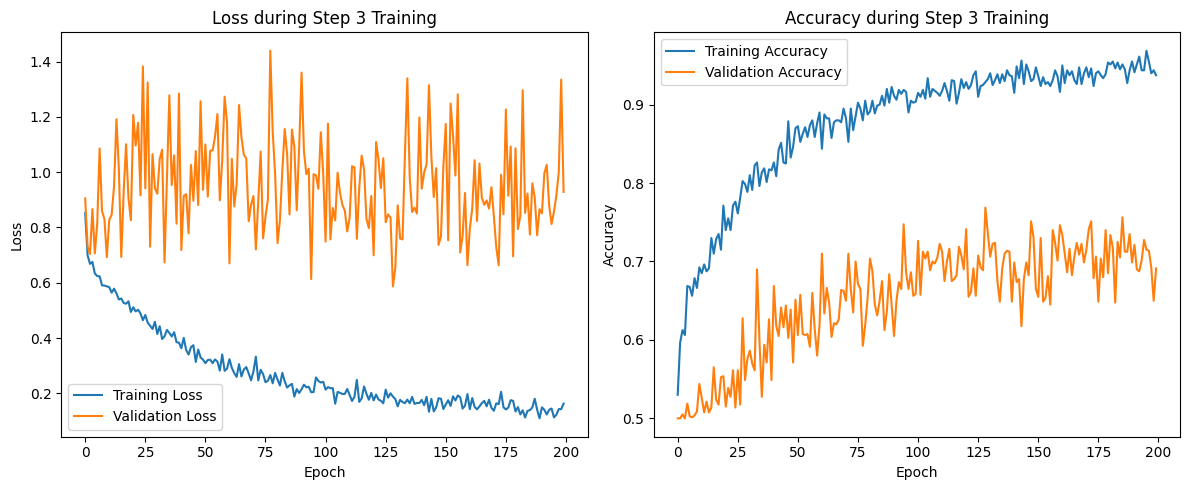

regularized model (model_regularized.pth) saved.


In [ ]:
# Ensure model_regularized, device, train_loader, val_loader,
# criterion_step3, and optimizer_step3 are defined correctly above this cell.

NUM_EPOCHS_STEP3 = 200  # DO NOT change

train_losses_step3 = []
train_accuracies_step3 = []
val_losses_step3 = []
val_accuracies_step3 = []

print(f"Starting Step 3 Training (Robust) for {NUM_EPOCHS_STEP3} epochs...")
print(f"Training on {len(train_loader.dataset)} images, Validating on {len(val_loader.dataset)} images.")

for epoch in range(NUM_EPOCHS_STEP3):
    model_regularized.train()
    running_loss_train = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    progress_bar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_STEP3} [Train]")
    for inputs, labels in progress_bar_train:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer_step3.zero_grad()
        outputs = model_regularized(inputs)
        loss = criterion_step3(outputs, labels)
        loss.backward()
        optimizer_step3.step()

        running_loss_train += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()

        progress_bar_train.set_postfix({'loss': f"{loss.item():.4f}"})

    epoch_train_loss = running_loss_train / len(train_loader)
    epoch_train_accuracy = correct_predictions_train / total_samples_train
    train_losses_step3.append(epoch_train_loss)
    train_accuracies_step3.append(epoch_train_accuracy)

    model_regularized.eval()
    running_loss_val = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS_STEP3} [Val  ]")
        for inputs_val, labels_val in progress_bar_val:
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)

            outputs_val = model_regularized(inputs_val)
            loss_val = criterion_step3(outputs_val, labels_val)

            running_loss_val += loss_val.item()
            _, predicted_val = torch.max(outputs_val, 1)
            total_samples_val += labels_val.size(0)
            correct_predictions_val += (predicted_val == labels_val).sum().item()

            progress_bar_val.set_postfix({'loss': f"{loss_val.item():.4f}"})

    epoch_val_loss = running_loss_val / len(val_loader)
    epoch_val_accuracy = correct_predictions_val / total_samples_val
    val_losses_step3.append(epoch_val_loss)
    val_accuracies_step3.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS_STEP3}: "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

print("\nFinished Step 3 Training.")


# Step 4 - Test again for robustness

Starting Robustness Evaluation Suite for model: /content/model_regularized.pth


RUNNING TEST: Uniform Noise on VALIDATION Data (Eps=0.25)
Successfully loaded model from '/content/model_regularized.pth'.

Evaluating robustness: Mode='uniform', Epsilon=0.25
Dataset: /content/Data/val, Images: 800, Batch Size: 16


Attack: UNIFORM, Eps: 0.25: 100%|██████████| 50/50 [00:02<00:00, 17.01it/s]



--- Robustness Test Summary ---
Mode: UNIFORM, Epsilon: 0.25
Overall Accuracy on (Potentially) Perturbed Data: 68.50% (548/800)
Number of samples initially classified correctly by clean model: 553
Accuracy on perturbed subset of these initially correct samples: 96.75% (535/553)
Misclassification rate on perturbed subset of initially correct samples: 3.25%

Displaying up to 10 misclassified perturbed images:


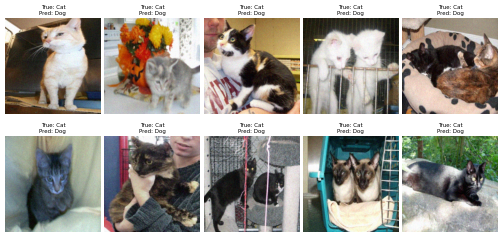


RUNNING TEST: FGSM on VALIDATION Data (Eps=0.05)
Successfully loaded model from '/content/model_regularized.pth'.

Evaluating robustness: Mode='fgsm', Epsilon=0.05
Dataset: /content/Data/val, Images: 800, Batch Size: 16


Attack: FGSM, Eps: 0.05: 100%|██████████| 50/50 [00:05<00:00,  9.72it/s]



--- Robustness Test Summary ---
Mode: FGSM, Epsilon: 0.05
Overall Accuracy on (Potentially) Perturbed Data: 20.00% (160/800)
Number of samples initially classified correctly by clean model: 553
Accuracy on perturbed subset of these initially correct samples: 28.93% (160/553)
Misclassification rate on perturbed subset of initially correct samples: 71.07%
Number of initially correct samples targeted by FGSM: 553
Number of successful FGSM flips (initially correct -> incorrect): 393
FGSM Attack Success Rate on targeted candidates: 71.07%

Displaying up to 10 misclassified perturbed images:


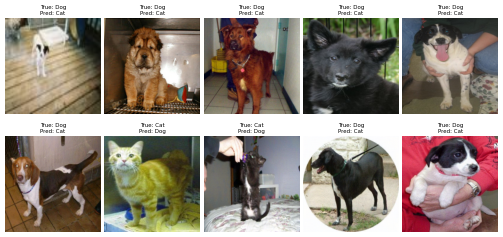


RUNNING TEST: Uniform Noise on TRAINING Data (Eps=0.25)
Successfully loaded model from '/content/model_regularized.pth'.

Evaluating robustness: Mode='uniform', Epsilon=0.25
Dataset: /content/Data/train, Images: 800, Batch Size: 16


Attack: UNIFORM, Eps: 0.25: 100%|██████████| 50/50 [00:03<00:00, 14.89it/s]



--- Robustness Test Summary ---
Mode: UNIFORM, Epsilon: 0.25
Overall Accuracy on (Potentially) Perturbed Data: 89.25% (714/800)
Number of samples initially classified correctly by clean model: 740
Accuracy on perturbed subset of these initially correct samples: 95.95% (710/740)
Misclassification rate on perturbed subset of initially correct samples: 4.05%

Displaying up to 10 misclassified perturbed images:


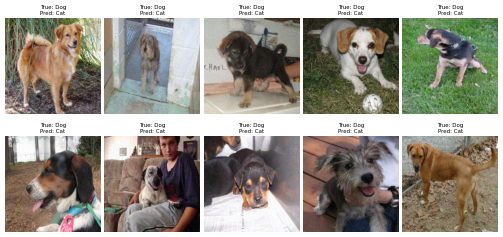


RUNNING TEST: FGSM on TRAINING Data (Eps=0.05)
Successfully loaded model from '/content/model_regularized.pth'.

Evaluating robustness: Mode='fgsm', Epsilon=0.05
Dataset: /content/Data/train, Images: 800, Batch Size: 16


Attack: FGSM, Eps: 0.05: 100%|██████████| 50/50 [00:05<00:00,  9.81it/s]



--- Robustness Test Summary ---
Mode: FGSM, Epsilon: 0.05
Overall Accuracy on (Potentially) Perturbed Data: 34.75% (278/800)
Number of samples initially classified correctly by clean model: 740
Accuracy on perturbed subset of these initially correct samples: 37.57% (278/740)
Misclassification rate on perturbed subset of initially correct samples: 62.43%
Number of initially correct samples targeted by FGSM: 740
Number of successful FGSM flips (initially correct -> incorrect): 462
FGSM Attack Success Rate on targeted candidates: 62.43%

Displaying up to 10 misclassified perturbed images:


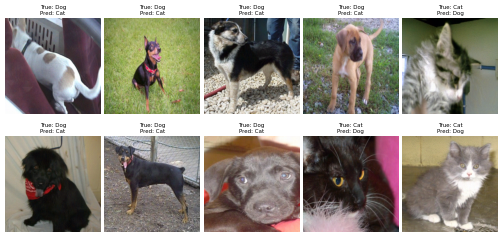


Robustness Evaluation Suite Completed.


In [28]:
run_robustness_evaluation_suite("/content/model_regularized.pth", RegularizedCNN)

# Beyond the shore

Hey! You are here! Congrats on Completing the assignment!

Hope you enjoyed the assignment, and learned something new along the way.

Your feedback is dearly welcome at @p3dr4m0098@telegram

Moving forward, you are now on your own; feel free to experiment as you wish.
Some suggestions are:

1. Try to fit the model further
    1. Add more expressive power to the model architecture
    2. Hyperparameter tuning
    3. Give the model more data

2. Experiment further with perturbation
    1. Perhaps more advanced attacks?
    2. Other types of random noise
        1. in one straight line
        2. non-uniform (e.g. Gaussian)